# A/B TEST

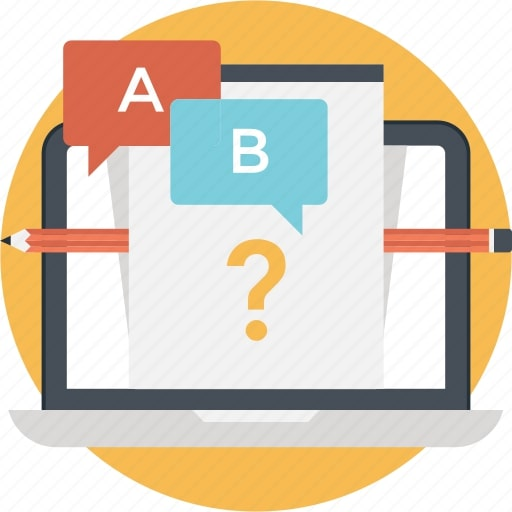

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.stats.api as sms
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu, f_oneway, kruskal

C:\Users\lenovo\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.style.use('fivethirtyeight')

In [4]:
df_ = pd.read_csv("WA_Marketing-Campaign.csv")

In [5]:
df = df_.copy()

### Data story

###### MarketID: unique identifier for market
###### MarketSize: size of market area by sales
###### LocationID: unique identifier for store location
###### AgeOfStore: age of store in years
###### Promotion: one of three promotions that were tested
###### week: one of four weeks when the promotions were run
###### SalesInThousands: sales amount for a specific LocationID, Promotion, and week


In [6]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MarketID,548.0,5.715328,2.877001,1.00,3.000,6.0,8.0000,10.00
LocationID,548.0,479.656934,287.973679,1.00,216.000,504.0,708.0000,920.00
AgeOfStore,548.0,8.503650,6.638345,1.00,4.000,7.0,12.0000,28.00
Promotion,548.0,2.029197,0.810729,1.00,1.000,2.0,3.0000,3.00
week,548.0,2.500000,1.119055,1.00,1.750,2.5,3.2500,4.00
SalesInThousands,548.0,53.466204,16.755216,17.34,42.545,50.2,60.4775,99.65


### Anova (Analysis of Variance)
##### It is used to compare the mean of more than two groups.

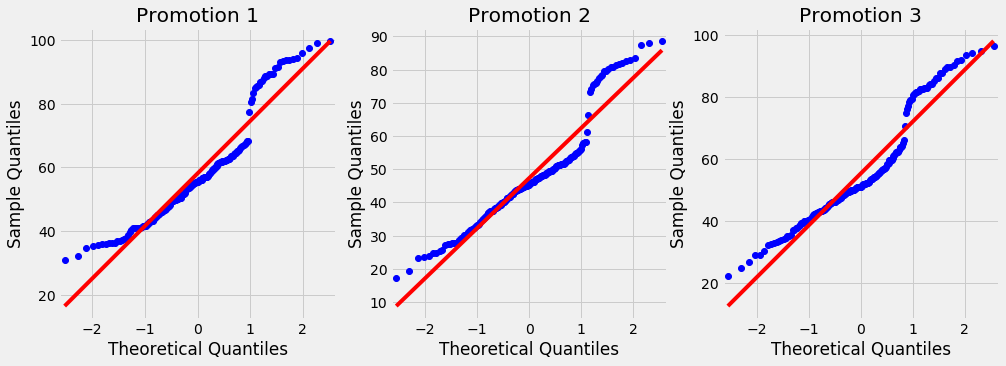

In [24]:
fig , axs = plt.subplots(1,3,figsize=(15,5))

qqplot(np.array(df.loc[(df["Promotion"] == 1), "SalesInThousands"]), line="s", ax=axs[0])
qqplot(np.array(df.loc[(df["Promotion"] == 2), "SalesInThousands"]), line="s", ax=axs[1])
qqplot(np.array(df.loc[(df["Promotion"] == 3), "SalesInThousands"]), line="s", ax=axs[2])

axs[0].set_title("Promotion 1")
axs[1].set_title("Promotion 2")
axs[2].set_title("Promotion 3")



plt.show()

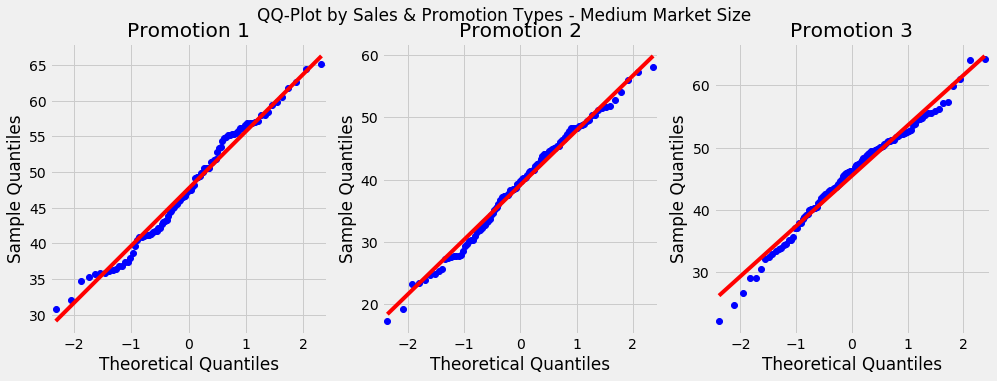

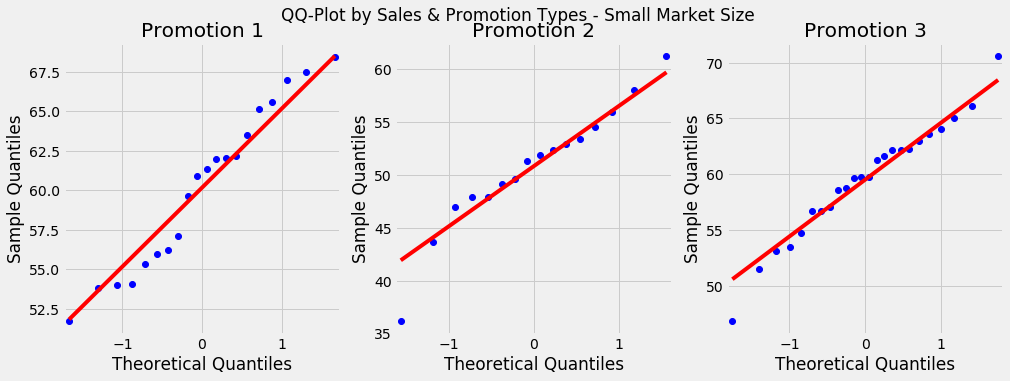

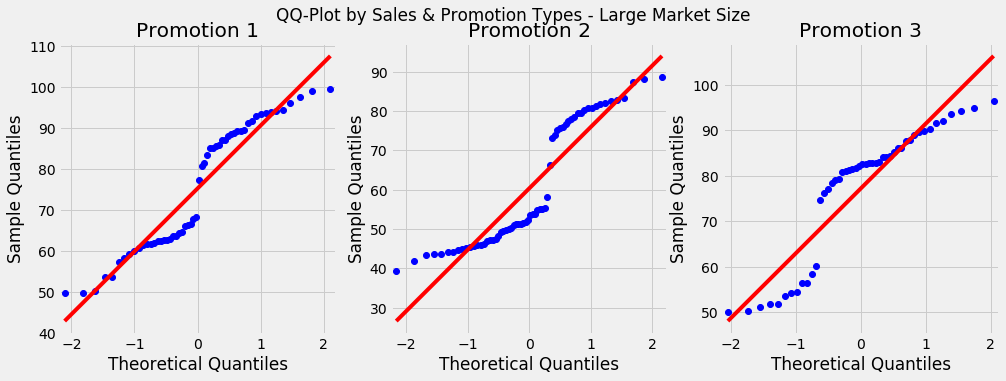

In [25]:
market_size = df["MarketSize"].unique()

for market_size in market_size:
    
    fig , axs = plt.subplots(1,3,figsize=(15,5))

    qqplot(np.array(df.loc[(df["Promotion"] == 1) & (df["MarketSize"] == market_size), "SalesInThousands"]), line="s", ax=axs[0])
    qqplot(np.array(df.loc[(df["Promotion"] == 2) & (df["MarketSize"] == market_size), "SalesInThousands"]), line="s", ax=axs[1])
    qqplot(np.array(df.loc[(df["Promotion"] == 3) & (df["MarketSize"] == market_size), "SalesInThousands"]), line="s", ax=axs[2])

    axs[0].set_title("Promotion 1")
    axs[1].set_title("Promotion 2")
    axs[2].set_title("Promotion 3")


    fig.suptitle(f"QQ-Plot by Sales & Promotion Types - {market_size} Market Size")
    plt.show() 

#### 1-) Normality assumption - Shapiro Wilk Test

In [15]:
for promotion in list (df["Promotion"].unique()):
    pvalue = shapiro(df.loc[df["Promotion"] == promotion, "SalesInThousands"])[1]
    print("Promotion:", promotion, "p-value: %.4f" % (pvalue))

Promotion: 3 p-value: 0.0000
Promotion: 2 p-value: 0.0000
Promotion: 1 p-value: 0.0000


#### 2-) Variance Homogeneity - Levene Test

In [27]:
test_stat, pvalue = levene(df.loc[df["Promotion"] == 1, "SalesInThousands"],
                           df.loc[df["Promotion"] == 2, "SalesInThousands"],
                           df.loc[df["Promotion"] == 3, "SalesInThousands"])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 1.2697, p-value = 0.2818


In [29]:
df.groupby("Promotion").agg({"SalesInThousands":["count","mean","median"]})

SalesInThousands                   
                     count       mean  median
Promotion                                    
1                      172  58.099012  55.385
2                      188  47.329415  45.385
3                      188  55.364468  51.165

In [30]:
df.groupby(["MarketSize","Promotion"]).agg({"SalesInThousands":["count","mean","median"]})

SalesInThousands                   
                                count       mean  median
MarketSize Promotion                                    
Large      1                       56  75.235893  72.835
           2                       64  60.322031  53.010
           3                       48  77.203958  82.345
Medium     1                       96  47.672604  47.425
           2                      108  39.114352  39.765
           3                      116  45.468879  46.295
Small      1                       20  60.162500  61.145
           2                       16  50.810625  51.600
           3                       24  59.514167  59.745

#### 3-) Nonparametrik ANOVA Test - Kruskal Wallis

In [31]:
kruskal(df.loc[df["Promotion"] == 1, "SalesInThousands"],
        df.loc[df["Promotion"] == 2, "SalesInThousands"],
        df.loc[df["Promotion"] == 3, "SalesInThousands"])

KruskalResult(statistic=53.29475169322799, pvalue=2.6741866266697816e-12)

#### 4-) Tukey Test  

In [33]:
from statsmodels.stats.multicomp import MultiComparison
comparison = MultiComparison(df["SalesInThousands"], df["Promotion"])
tukey = comparison.tukeyhsd(0.05)
print(comparison.tukeyhsd(0.05))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2 -10.7696  0.001 -14.774 -6.7652   True
     1      3  -2.7345 0.2447 -6.7389  1.2698  False
     2      3   8.0351  0.001  4.1207 11.9494   True
----------------------------------------------------


In [34]:
df.groupby("Promotion").agg({"SalesInThousands":["count","mean","median"]})

SalesInThousands                   
                     count       mean  median
Promotion                                    
1                      172  58.099012  55.385
2                      188  47.329415  45.385
3                      188  55.364468  51.165